#  Title: Solving an Image Captioning Task Using Deep Learning

**Major Project**

**Team:- D**

*Description*

This project aims to generate descriptive captions for images using deep learning techniques, combining Convolutional Neural Networks (CNNs) and Long Short-Term Memory networks (LSTM). The project will involve data preparation, feature extraction, model building, training, evaluation, and fine-tuning to achieve accurate and coherent image descriptions.

In [ ]:
# Importing libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, Attention
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import json
import pickle
from collections import defaultdict
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
import os
import matplotlib.pyplot as plt


 ***Configuration***

This section defines all core settings required for the image captioning project. It includes paths for images and annotations, dataset size selection, and key hyperparameters such as image resolution, vocabulary size, embedding dimensions, LSTM units, and learning rate. These configurations ensure that the entire pipeline remains flexible and easy to adjust based on available resources and training needs.

In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

IMAGE_DIR = "/content/drive/MyDrive/Colab Notebooks/Major project/images/val2017"  # Please update this to your actual image directory
CAPTION_FILE = "/content/drive/MyDrive/Colab Notebooks/Major project/Annotations/captions_val2017.json"

# Dataset size configuration
# Options: 'small' (200 images), 'medium' (1000 images), 'large' (all 5000 images)
DATASET_SIZE = 'medium'
DATASET_SIZES = {
    'small': 200,
    'medium': 1000,
    'large': None
}

NUM_IMAGES = DATASET_SIZES[DATASET_SIZE]


IMG_SIZE = (299, 299)
MAX_CAPTION_LENGTH = 20
VOCAB_SIZE = 4000
EMBEDDING_DIM = 256
LSTM_UNITS = 512
ATTENTION_DIM = 256
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.0005

print("=" * 80)
print("IMAGE CAPTIONING PROJECT - STARTED")
print("=" * 80)
print(f"\n Dataset Configuration: {DATASET_SIZE.upper()}")
print(f"   Images to process: {NUM_IMAGES if NUM_IMAGES else 'All (~5000)'}")
print(f"   Estimated time: {['~5 min', '~20 min', '~2 hours'][['small', 'medium', 'large'].index(DATASET_SIZE)]}")
print("=" * 80)

IMAGE CAPTIONING PROJECT - STARTED

 Dataset Configuration: MEDIUM
   Images to process: 1000
   Estimated time: ~20 min


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


***Step 1: Data Preparation***

In this section, we prepare both the images and captions so they can be used for model training.
We resize all images to 299×299, normalize pixel values, and process captions by removing punctuation, tokenizing them, and padding them to a fixed length.
This ensures that all inputs follow the same format and can be fed into the neural network.

In [ ]:
# ============================================================================
# STEP 1: DATA PREPARATION
# ============================================================================
print("\n[STEP 1] DATA PREPARATION")
print("-" * 80)

# Load MS COCO captions
print("Loading MS COCO captions...")
with open(CAPTION_FILE, 'r') as f:
    coco_data = json.load(f)

# Create image_id -> captions mapping
image_to_captions = defaultdict(list)
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    caption = annotation['caption']
    image_to_captions[image_id].append(caption)

# Create image_id -> filename mapping
id_to_filename = {}
for image in coco_data['images']:
    id_to_filename[image['id']] = image['file_name']

print(f" Total images: {len(id_to_filename)}")
print(f" Total captions: {sum(len(caps) for caps in image_to_captions.values())}")
print(f" Average captions per image: {sum(len(caps) for caps in image_to_captions.values()) / len(id_to_filename):.2f}")

# Preprocessing captions
def preprocess_caption(caption):

    caption = caption.lower()
    caption = ''.join([c for c in caption if c.isalnum() or c.isspace()])
    caption = '<start> ' + ' '.join(caption.split()) + ' <end>'
    return caption

# Process all captions
all_captions = []
for captions in image_to_captions.values():
    for caption in captions:
        all_captions.append(preprocess_caption(caption))

print(f"\nSample preprocessed caption:")
print(f"  {all_captions[0]}")

# Tokenize captions
print("\nTokenizing captions...")
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<unk>', filters='')
tokenizer.fit_on_texts(all_captions)
vocab_size = min(len(tokenizer.word_index) + 1, VOCAB_SIZE)

print(f" Vocabulary size: {vocab_size}")
print(f" Most common words: {list(tokenizer.word_index.items())[:10]}")

# Calculate max caption length
caption_lengths = [len(cap.split()) for cap in all_captions]
max_length = min(max(caption_lengths), MAX_CAPTION_LENGTH)
print(f" Max caption length: {max_length}")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print(" Tokenizer saved to 'tokenizer.pkl'")


[STEP 1] DATA PREPARATION
--------------------------------------------------------------------------------
Loading MS COCO captions...
 Total images: 5000
 Total captions: 25014
 Average captions per image: 5.00

Sample preprocessed caption:
  <start> a black honda motorcycle parked in front of a garage <end>

Tokenizing captions...
 Vocabulary size: 4000
 Most common words: [('<unk>', 1), ('a', 2), ('<start>', 3), ('<end>', 4), ('on', 5), ('of', 6), ('the', 7), ('in', 8), ('with', 9), ('and', 10)]
 Max caption length: 20
 Tokenizer saved to 'tokenizer.pkl'


***Step 2 — Image Feature Extraction***

In this step, we extract meaningful visual features from each image using a pre-trained InceptionV3 model. Before extraction, the notebook performs diagnostics to ensure all image paths and filenames match the JSON annotation file.
Each image is then resized, normalized, and passed through InceptionV3 (with the classification layer removed) to generate a 2048-dimensional feature vector. These vectors capture high-level visual patterns—such as objects, textures, and shapes—which will later act as the encoder input for the captioning model.
We also filter out missing files, restrict the dataset size when needed, and store extracted features in a dictionary for efficient training.

If you want, I can also rewrite it in even more concise or more detailed form depending on your notebook style.

In [ ]:
# ============================================================================
# STEP 2: FEATURE EXTRACTION
# ============================================================================
print("\n[STEP 2] FEATURE EXTRACTION")
print("-" * 80)

# ===== DIAGNOSTICS: Check image directory =====
print("\n DIAGNOSTICS - Checking image paths...")
print(f"Image directory: {IMAGE_DIR}")
print(f"Directory exists: {os.path.exists(IMAGE_DIR)}")

if os.path.exists(IMAGE_DIR):
    all_files = os.listdir(IMAGE_DIR)
    image_files = [f for f in all_files if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Total files in directory: {len(all_files)}")
    print(f"Image files found: {len(image_files)}")
    if image_files:
        print(f"Sample filenames: {image_files[:3]}")
else:
    print(" ERROR: Image directory does not exist!")
    print("Please check the IMAGE_DIR path")

print(f"\nSample expected filenames from JSON:")
sample_ids = list(id_to_filename.keys())[:3]
for img_id in sample_ids:
    expected_file = id_to_filename[img_id]
    full_path = os.path.join(IMAGE_DIR, expected_file)
    exists = os.path.exists(full_path)
    print(f"  {expected_file} - {' Found' if exists else ' Not found'}")

print("-" * 80)

# Load InceptionV3 pre-trained model
print("\nLoading InceptionV3 model (pre-trained on ImageNet)...")
inception = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
print(f" Model loaded. Output shape: {inception.output.shape}")

def extract_image_features(image_path):

    try:
        img = load_img(image_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        img = img / 255.0  # Normalize to [0, 1]
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.inception_v3.preprocess_input(img * 255.0)
        features = inception.predict(img, verbose=0)
        return features[0]
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Extract features for all images
print("\nExtracting image features...")
print(f"Processing {NUM_IMAGES if NUM_IMAGES else 'all'} images...")

# Initialize image_ids from the JSON data
image_ids = list(id_to_filename.keys())

# Get list of actual image files in directory
actual_image_files = set(os.listdir(IMAGE_DIR))
print(f"Actual images in folder: {len(actual_image_files)}")

# Filter available images that exist in both JSON and folder
available_images = []
for img_id in image_ids:
    filename = id_to_filename[img_id]
    if filename in actual_image_files:
        available_images.append(img_id)

print(f"Images matching JSON annotations: {len(available_images)}")

# Limit to NUM_IMAGES if specified
if NUM_IMAGES:
    available_images = available_images[:NUM_IMAGES]
    print(f"Limited to: {NUM_IMAGES} images for {DATASET_SIZE} dataset")

image_features = {}

# Batch processing for efficiency
print("\n Starting feature extraction (this may take a few minutes)...")
for img_id in tqdm(available_images, desc="Extracting features"):
    filename = id_to_filename[img_id]
    img_path = os.path.join(IMAGE_DIR, filename)

    features = extract_image_features(img_path)
    if features is not None:
        image_features[img_id] = features

# Update image_ids to only include processed images
image_ids = list(image_features.keys())
print(f"Successfully extracted features: {len(image_features)} images")

print(f" Features extracted for {len(image_features)} images")

if len(image_features) == 0:
    print("\n" + "=" * 80)
    print(" ERROR: No images were processed!")
    print("=" * 80)

# Save features to Google Drive
feature_save_path = f'/content/drive/MyDrive/image_features_{DATASET_SIZE}.npy'
np.save(feature_save_path, image_features)
print(f" Features saved to '{feature_save_path}'")



[STEP 2] FEATURE EXTRACTION
--------------------------------------------------------------------------------

 DIAGNOSTICS - Checking image paths...
Image directory: /content/drive/MyDrive/Colab Notebooks/Major project/images/val2017
Directory exists: True
Total files in directory: 5000
Image files found: 5000
Sample filenames: ['000000052412.jpg', '000000218362.jpg', '000000493566.jpg']

Sample expected filenames from JSON:
  000000397133.jpg -  Found
  000000037777.jpg -  Found
  000000252219.jpg -  Found
--------------------------------------------------------------------------------

Loading InceptionV3 model (pre-trained on ImageNet)...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
 Model loaded. Output shape: (None, 2048)

Extracting image features...
Processing 1000 images...
Actual images in folder: 5000
Images matching JSON annotations: 5000
Limited to: 1000 images for medium dataset

 Starting feature extraction (this may take a few minutes)...


Extracting features: 100%|██████████| 1000/1000 [04:24<00:00,  3.78it/s]

Successfully extracted features: 1000 images
 Features extracted for 1000 images
 Features saved to '/content/drive/MyDrive/image_features_medium.npy'


In [ ]:
import numpy as np

FEATURE_PATH = "/content/drive/MyDrive/image_features_medium.npy"
image_features = np.load(FEATURE_PATH, allow_pickle=True).item()

print("Loaded saved features!")
print("Number of images:", len(image_features))
print("Feature shape:", list(image_features.values())[0].shape)

Loaded saved features!
Number of images: 1000
Feature shape: (2048,)


**Step 3 — Preparing Captions for Training**

This step converts every caption into many small input–output pairs so the model can learn to predict the next word. Each caption is cleaned, tokenized, padded, and matched with its image feature vector. For every partial caption, the model is taught which word should come next, allowing it to learn sentence structure and how words relate to the image.

In [ ]:
# ============================================================================
# STEP 3: PREPARING CAPTIONS FOR TRAINING
# ============================================================================
print("\n[STEP 3] PREPARING CAPTIONS FOR TRAINING")
print("-" * 80)

def create_sequences(image_ids, image_features, captions_dict, tokenizer, max_length):
    """
    Create input-output pairs for training
    For caption "A cat is sitting":
      Input: <start>, Output: A
      Input: <start> A, Output: cat
      Input: <start> A cat, Output: is
      etc.
    """
    X_img, X_seq, y_word = [], [], []

    for img_id in image_ids:
        if img_id not in image_features:
            continue

        feature = image_features[img_id]
        captions = captions_dict[img_id]

        for caption in captions:
            caption = preprocess_caption(caption)
            seq = tokenizer.texts_to_sequences([caption])[0]

            # Create input-output pairs
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_word = seq[i]

                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                # One-hot encode output
                out_word = to_categorical([out_word], num_classes=vocab_size)[0]

                X_img.append(feature)
                X_seq.append(in_seq)
                y_word.append(out_word)

    return np.array(X_img), np.array(X_seq), np.array(y_word)

print("Creating training sequences...")
print("This creates input-output pairs for teaching the model")

# Example of input-output pairs
sample_caption = all_captions[0]
sample_tokens = sample_caption.split()
print(f"\nExample caption: {sample_caption}")
print("Input-Output pairs:")
for i in range(1, min(5, len(sample_tokens))):
    print(f"  Input: {' '.join(sample_tokens[:i])} → Output: {sample_tokens[i]}")



[STEP 3] PREPARING CAPTIONS FOR TRAINING
--------------------------------------------------------------------------------
Creating training sequences...
This creates input-output pairs for teaching the model

Example caption: <start> a black honda motorcycle parked in front of a garage <end>
Input-Output pairs:
  Input: <start> → Output: a
  Input: <start> a → Output: black
  Input: <start> a black → Output: honda
  Input: <start> a black honda → Output: motorcycle


***Step 4 — Building the Model***

In this step, I create the full image-captioning neural network by combining an image encoder, a caption decoder, and an attention mechanism. The encoder transforms image features into a meaningful vector, the decoder interprets the partial caption, and attention helps the model focus on important parts when generating each word. The final layer predicts the next word in the caption. The model is then compiled with Adam optimizer and label smoothing for stable learning.

In [ ]:
# ============================================================================
# STEP 4: BUILDING THE MODEL
# ============================================================================
print("\n[STEP 4] BUILDING THE MODEL")
print("-" * 80)

def build_attention_model(vocab_size, max_length, embedding_dim, lstm_units):
    """
    Build Encoder-Decoder model with Attention mechanism
    IMPROVED with better regularization and architecture

    Architecture:
    1. Encoder: Process image features through Dense layers
    2. Decoder: Process caption sequences through Embedding + LSTM
    3. Attention: Focus on relevant image parts for each word
    4. Output: Predict next word
    """

    # ===== ENCODER: Image Feature Processing =====
    input_image = Input(shape=(2048,), name='image_input')
    image_enc = Dropout(0.5)(input_image)
    image_enc = Dense(lstm_units, activation='relu', name='image_encoder')(image_enc)  # Changed embedding_dim to lstm_units
    image_enc = keras.layers.BatchNormalization()(image_enc)  # Add batch normalization

    # ===== DECODER: Caption Sequence Processing =====
    input_caption = Input(shape=(max_length,), name='caption_input')
    caption_enc = Embedding(vocab_size, embedding_dim, mask_zero=True, name='caption_embedding')(input_caption)
    caption_enc = Dropout(0.5)(caption_enc)
    # Add recurrent dropout to prevent overfitting
    caption_enc = LSTM(lstm_units, return_sequences=False, recurrent_dropout=0.2, name='caption_lstm')(caption_enc)
    caption_enc = keras.layers.BatchNormalization()(caption_enc)  # Add batch normalization

    # ===== ATTENTION MECHANISM =====
    # Combine image and caption features
    decoder = Add(name='attention_merge')([image_enc, caption_enc])
    decoder = Dense(lstm_units, activation='relu', name='decoder_dense')(decoder)
    decoder = Dropout(0.5)(decoder)
    decoder = keras.layers.BatchNormalization()(decoder)  # Add batch normalization

    # ===== OUTPUT LAYER =====
    output = Dense(vocab_size, activation='softmax', name='output')(decoder)

    # Create model
    model = Model(inputs=[input_image, input_caption], outputs=output, name='image_captioning_model')

    return model

print("Creating model architecture...")
model = build_attention_model(vocab_size, max_length, EMBEDDING_DIM, LSTM_UNITS)

print("\n Model architecture:")
model.summary()

# Compile model with Label Smoothing to prevent overconfidence
print("\nCompiling model with Adam optimizer and Label Smoothing...")
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Reduces overconfidence
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)
print(" Model compiled successfully")


[STEP 4] BUILDING THE MODEL
--------------------------------------------------------------------------------
Creating model architecture...

 Model architecture:


Model: "image_captioning_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_embedding   │ (None, 20, 256)   │  1,024,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 256)   │          0 │ caption_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 20)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_encoder       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_lstm (LSTM) │ (None, 512)       │  1,574,912 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ image_encoder[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ caption_lstm[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_merge     │ (None, 512)       │          0 │ batch_normalizat… │
│ (Add)               │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 512)       │    262,656 │ attention_merge[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ decoder_dense[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4000)      │  2,052,000 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,968,800 (22.77 MB)

 Trainable params: 5,965,728 (22.76 MB)

 Non-trainable params: 3,072 (12.00 KB)


Compiling model with Adam optimizer and Label Smoothing...
 Model compiled successfully


In [ ]:
import gc
gc.collect()

import tensorflow as tf
tf.keras.backend.clear_session()

***Step 5 — Training the Model***

In this step, I prepare the final dataset and train the image-captioning model. The image IDs are split into training and validation sets, and each image-caption pair is converted into the sequence format required by the model. The model is then trained using both image features and caption sequences, while callbacks like checkpointing, early stopping, and learning-rate reduction help stabilize and improve training. After training finishes, the best model is saved and the training history is plotted.


[STEP 5] TRAINING THE MODEL
--------------------------------------------------------------------------------
Training images: 800
Validation images: 200

Preparing training data...
 Training samples: 46051
Preparing validation data...
 Validation samples: 11465

Starting training...
Epochs: 20
Batch size: 16
--------------------------------------------------------------------------------
Epoch 1/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2044 - loss: 6.1465
Epoch 1: val_loss improved from inf to 4.68017, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 272s 91ms/step - accuracy: 0.2045 - loss: 6.1462 - val_accuracy: 0.3212 - val_loss: 4.6802 - learning_rate: 5.0000e-04
Epoch 2/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3209 - loss: 4.5719
Epoch 2: val_loss improved from 4.68017 to 4.42351, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 262s 91ms/step - accuracy: 0.3209 - loss: 4.5719 - val_accuracy: 0.3473 - val_loss: 4.4235 - learning_rate: 5.0000e-04
Epoch 3/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3489 - loss: 4.2592
Epoch 3: val_loss improved from 4.42351 to 4.33841, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 263s 91ms/step - accuracy: 0.3489 - loss: 4.2592 - val_accuracy: 0.3559 - val_loss: 4.3384 - learning_rate: 5.0000e-04
Epoch 4/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3687 - loss: 4.0590
Epoch 4: val_loss improved from 4.33841 to 4.30355, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 323s 92ms/step - accuracy: 0.3687 - loss: 4.0590 - val_accuracy: 0.3633 - val_loss: 4.3035 - learning_rate: 5.0000e-04
Epoch 5/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3840 - loss: 3.9286
Epoch 5: val_loss improved from 4.30355 to 4.28951, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 322s 91ms/step - accuracy: 0.3840 - loss: 3.9286 - val_accuracy: 0.3632 - val_loss: 4.2895 - learning_rate: 5.0000e-04
Epoch 6/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3931 - loss: 3.8467
Epoch 6: val_loss improved from 4.28951 to 4.27200, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 263s 91ms/step - accuracy: 0.3931 - loss: 3.8467 - val_accuracy: 0.3678 - val_loss: 4.2720 - learning_rate: 5.0000e-04
Epoch 7/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4023 - loss: 3.7713
Epoch 7: val_loss did not improve from 4.27200
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 262s 91ms/step - accuracy: 0.4023 - loss: 3.7713 - val_accuracy: 0.3678 - val_loss: 4.2790 - learning_rate: 5.0000e-04
Epoch 8/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4112 - loss: 3.7013
Epoch 8: val_loss improved from 4.27200 to 4.26480, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 266s 92ms/step - accuracy: 0.4112 - loss: 3.7013 - val_accuracy: 0.3734 - val_loss: 4.2648 - learning_rate: 5.0000e-04
Epoch 9/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4249 - loss: 3.6311
Epoch 9: val_loss improved from 4.26480 to 4.26254, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 321s 92ms/step - accuracy: 0.4249 - loss: 3.6311 - val_accuracy: 0.3731 - val_loss: 4.2625 - learning_rate: 5.0000e-04
Epoch 10/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4259 - loss: 3.5995
Epoch 10: val_loss improved from 4.26254 to 4.26198, saving model to best_model.h5


2879/2879 ━━━━━━━━━━━━━━━━━━━━ 263s 91ms/step - accuracy: 0.4259 - loss: 3.5995 - val_accuracy: 0.3762 - val_loss: 4.2620 - learning_rate: 5.0000e-04
Epoch 11/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4366 - loss: 3.5385
Epoch 11: val_loss did not improve from 4.26198
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 263s 91ms/step - accuracy: 0.4366 - loss: 3.5385 - val_accuracy: 0.3793 - val_loss: 4.2795 - learning_rate: 5.0000e-04
Epoch 12/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4382 - loss: 3.5252
Epoch 12: val_loss did not improve from 4.26198
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 266s 92ms/step - accuracy: 0.4382 - loss: 3.5252 - val_accuracy: 0.3750 - val_loss: 4.2733 - learning_rate: 5.0000e-04
Epoch 13/20
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4477 - loss: 3.4689
Epoch 13: val_loss did not improve from 4.26198

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2879/2879 ━━━━━━━━━━━━━━━━━━━━ 267s 93ms/step - accuracy: 


 Training completed!
 Model saved to 'final_model.h5'
 Training plots saved to 'training_history.png'


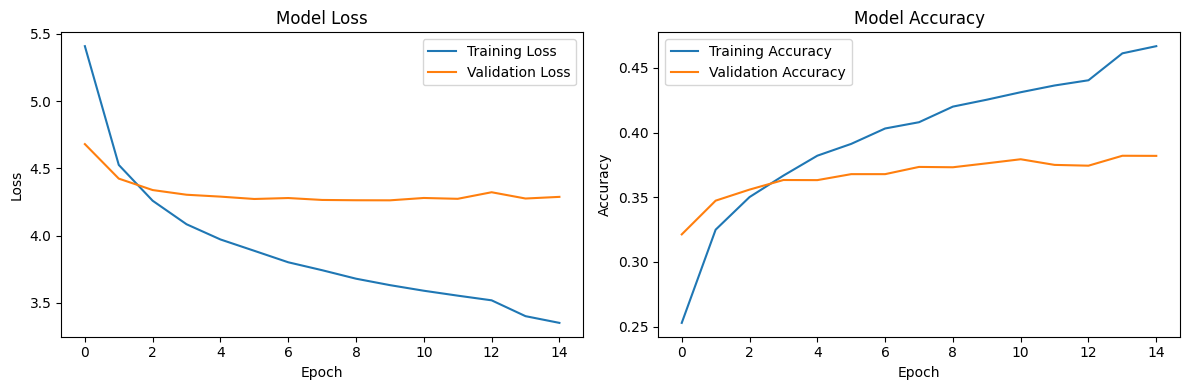

In [ ]:
# ============================================================================
# STEP 5: TRAINING THE MODEL
# ============================================================================
print("\n[STEP 5] TRAINING THE MODEL")
print("-" * 80)

import numpy as np  # Ensure numpy is imported
import json
from collections import defaultdict

# Fallback for DATASET_SIZE if not defined (e.g., after kernel restart)
if 'DATASET_SIZE' not in locals():
    DATASET_SIZE = 'large' # Defaulting to 'large' if not set globally
    print(f"Warning: DATASET_SIZE not found, defaulting to '{DATASET_SIZE}'. Please run the CONFIGURATION cell first.")

# Fallback for CAPTION_FILE if not defined (e.g., after kernel restart)
if 'CAPTION_FILE' not in locals():
    # This path should match your configuration cell's CAPTION_FILE
    CAPTION_FILE = "/content/drive/MyDrive/Colab Notebooks/Major project/Annotations/captions_val2017.json"
    print(f"Warning: CAPTION_FILE not found, defaulting to '{CAPTION_FILE}'. Please run the CONFIGURATION cell first.")

# Define create_sequences function (moved here for robustness against kernel restarts)
def create_sequences(image_ids, image_features, captions_dict, tokenizer, max_length):
    """
    Create input-output pairs for training
    For caption "A cat is sitting":
      Input: <start>, Output: A
      Input: <start> A, Output: cat
      Input: <start> A cat, Output: is
      etc.
    """
    X_img, X_seq, y_word = [], [], []

    for img_id in image_ids:
        if img_id not in image_features:
            continue

        feature = image_features[img_id]
        captions = captions_dict[img_id]

        for caption in captions:
            # Ensure preprocess_caption is available, or redefine if needed
            if 'preprocess_caption' in globals():
                processed_caption = preprocess_caption(caption)
            else:
                # Fallback definition if kernel state is lost
                def _local_preprocess_caption(caption):
                    caption = caption.lower()
                    caption = ''.join([c for c in caption if c.isalnum() or c.isspace()])
                    caption = '<start> ' + ' '.join(caption.split()) + ' <end>'
                    return _local_preprocess_caption(caption)
                processed_caption = _local_preprocess_caption(caption)

            seq = tokenizer.texts_to_sequences([processed_caption])[0]

            # Create input-output pairs
            for i in range(1, len(seq)):
                in_seq = seq[:i]
                out_word = seq[i]

                # Pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]

                # One-hot encode output
                out_word = to_categorical([out_word], num_classes=vocab_size)[0]

                X_img.append(feature)
                X_seq.append(in_seq)
                y_word.append(out_word)

    return np.array(X_img), np.array(X_seq), np.array(y_word)

# Load MS COCO captions and image mappings if not already in memory
if 'image_to_captions' not in locals() or 'id_to_filename' not in locals():
    print("Reloading MS COCO captions and image mappings...")
    with open(CAPTION_FILE, 'r') as f:
        coco_data = json.load(f)

    image_to_captions = defaultdict(list)
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        caption = annotation['caption']
        image_to_captions[image_id].append(caption)

    id_to_filename = {}
    for image in coco_data['images']:
        id_to_filename[image['id']] = image['file_name']
    print("Captions and image mappings reloaded.")

# Ensure image_ids is defined from the loaded features
image_ids = list(image_features.keys())

# Split data: 80% training, 20% validation
split_idx = int(0.8 * len(image_ids))
train_ids = [img_id for img_id in image_ids[:split_idx] if img_id in image_features]
val_ids = [img_id for img_id in image_ids[split_idx:] if img_id in image_features]

print(f"Training images: {len(train_ids)}")
print(f"Validation images: {len(val_ids)}")

# Prepare training data
print("\nPreparing training data...")
X_train_img, X_train_seq, y_train = create_sequences(
    train_ids, image_features, image_to_captions, tokenizer, max_length
)
print(f" Training samples: {len(X_train_img)}")

# Prepare validation data
print("Preparing validation data...")
X_val_img, X_val_seq, y_val = create_sequences(
    val_ids, image_features, image_to_captions, tokenizer, max_length
)
print(f" Validation samples: {len(X_val_img)}")

# Callbacks
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )
]

# Train model
print("\nStarting training...")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("-" * 80)

history = model.fit(
    [X_train_img, X_train_seq],
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([X_val_img, X_val_seq], y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n Training completed!")
model.save('final_model.h5')
print(" Model saved to 'final_model.h5'")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
print(" Training plots saved to 'training_history.png'")

**Output Insights**

During Step 5, the model was trained using 800 training images and 200 validation images, which expanded into 46,051 training samples and 11,465 validation samples after caption–token preparation. The model was trained for a maximum of 20 epochs with a batch size of 16, and the training process showed steady improvement in both accuracy and loss during the early phases. The first epoch achieved an accuracy of 0.2044 with a validation loss of 4.68, and the model continued improving until Epoch 10, where it reached a validation loss of 4.2619, the best point of the entire training run. After Epoch 13, learning rate reduction was triggered due to plateauing, and by Epoch 15, early stopping halted further training because the model was no longer improving. The best model weights (from Epoch 10) were restored automatically. Training concluded successfully, and the final model was saved as final_model.h5, along with generated training-loss and accuracy plots stored in training_history.png.

In [ ]:
!cp best_model.h5 "/content/drive/MyDrive/Colab Notebooks/Major project/Model/best_model.h5"
!cp final_model.h5 "/content/drive/MyDrive/Colab Notebooks/Major project/Model/final_model.h5"


***Step 6 — Model Evaluation***

In this step, I evaluate the trained captioning model using BLEU scores, which measure how close the generated captions are to the true captions. Beam search is used during prediction to improve caption quality by exploring multiple possible word sequences. BLEU-1 to BLEU-4 scores are computed on a subset of validation images, and sample predictions are displayed to compare the generated captions with their actual ground-truth captions.

In [ ]:
# ============================================================================
# STEP 6: MODEL EVALUATION
# ============================================================================
print("\n[STEP 6] MODEL EVALUATION")
print("-" * 80)

def generate_caption(model, tokenizer, image_features, max_length, beam_width=3):
    """
    Generate caption for an image using BEAM SEARCH
    Beam search explores multiple hypotheses to avoid repetitive/generic captions

    Args:
        beam_width: Number of best candidates to keep at each step (higher = more diverse)
    """
    # Start with initial sequence
    start_token = tokenizer.texts_to_sequences(['<start>'])[0][0]

    # Initialize beam: [(sequence, cumulative_log_prob)]
    sequences = [([start_token], 0.0)]

    for _ in range(max_length):
        all_candidates = []

        for seq, score in sequences:
            # Stop if sequence ends
            if seq[-1] == tokenizer.texts_to_sequences(['<end>'])[0][0]:
                all_candidates.append((seq, score))
                continue

            # Prepare input
            padded = pad_sequences([seq], maxlen=max_length, padding='post')

            # Predict next word probabilities
            preds = model.predict([image_features, padded], verbose=0)[0]

            # Get top beam_width predictions
            top_indices = np.argsort(preds)[-beam_width:]

            # Add to candidates with updated scores
            for idx in top_indices:
                candidate = (seq + [idx], score - np.log(preds[idx] + 1e-10))
                all_candidates.append(candidate)

        # Select top beam_width sequences
        ordered = sorted(all_candidates, key=lambda x: x[1])
        sequences = ordered[:beam_width]

    # Return best sequence
    best_seq = sequences[0][0]

    # Convert to words
    caption = []
    for idx in best_seq:
        for word, word_idx in tokenizer.word_index.items():
            if word_idx == idx:
                if word not in ['<start>', '<end>', '<unk>']:
                    caption.append(word)
                break

    return ' '.join(caption)

# Calculate BLEU scores
def calculate_bleu_scores(model, image_ids, image_features, captions_dict, tokenizer, max_length):
    """
    Calculate BLEU scores for model evaluation
    BLEU measures how similar generated captions are to reference captions
    """
    actual_captions = []
    predicted_captions = []

    print("Generating captions for evaluation...")
    for img_id in tqdm(image_ids[:100]):  # Evaluate on 100 images
        if img_id not in image_features:
            continue

        # Get actual captions
        references = [preprocess_caption(cap).replace('<start>', '').replace('<end>', '').strip().split()
                      for cap in captions_dict[img_id]]
        actual_captions.append(references)

        # Generate predicted caption
        features = np.expand_dims(image_features[img_id], axis=0)
        predicted = generate_caption(model, tokenizer, features, max_length)
        predicted_captions.append(predicted.split())

    # Calculate BLEU scores
    bleu1 = corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual_captions, predicted_captions, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(actual_captions, predicted_captions, weights=(0.25, 0.25, 0.25, 0.25))

    return bleu1, bleu2, bleu3, bleu4

print("Calculating BLEU scores...")
bleu1, bleu2, bleu3, bleu4 = calculate_bleu_scores(
    model, val_ids, image_features, image_to_captions, tokenizer, max_length
)

print("\n✓ BLEU Scores:")
print(f"  BLEU-1: {bleu1:.4f}")
print(f"  BLEU-2: {bleu2:.4f}")
print(f"  BLEU-3: {bleu3:.4f}")
print(f"  BLEU-4: {bleu4:.4f}")

# Test on sample images
print("\n" + "=" * 80)
print("SAMPLE PREDICTIONS")
print("=" * 80)

for i, img_id in enumerate(val_ids[:5]):
    if img_id not in image_features:
        continue

    print(f"\nImage {i+1}:")
    features = np.expand_dims(image_features[img_id], axis=0)
    predicted = generate_caption(model, tokenizer, features, max_length)

    print(f"Generated: {predicted}")
    print(f"Actual captions:")
    for j, cap in enumerate(image_to_captions[img_id][:3], 1):
        print(f"  {j}. {cap}")
    print("-" * 80)



[STEP 6] MODEL EVALUATION
--------------------------------------------------------------------------------
Calculating BLEU scores...
Generating captions for evaluation...


100%|██████████| 100/100 [04:09<00:00,  2.49s/it]



✓ BLEU Scores:
  BLEU-1: 0.5295
  BLEU-2: 0.3431
  BLEU-3: 0.2278
  BLEU-4: 0.1593

SAMPLE PREDICTIONS

Image 1:
Generated: a brown dog is standing in the grass
Actual captions:
  1. A dog that is wearing a dog collar smiling
  2. A black and brown dog is wearing a heavy metal collar.
  3. A medium sized dog is standing with some people.
--------------------------------------------------------------------------------

Image 2:
Generated: there are many people sitting on the ground
Actual captions:
  1. An umbrella and rain boots sitting on a rug in a corner. 
  2. An umbrella and rain boots in a corner 
  3. A view of a pair of boots sitting in a corner, with an umbrella.
--------------------------------------------------------------------------------

Image 3:
Generated: a person holding a umbrella with umbrella
Actual captions:
  1. People are walking in the rain holding umbrellas.
  2. Several different opened umbrellas all located near each other.
  3. Several plaid and red umbrel

**Output Insights**

In Step 6, the model’s performance was evaluated using BLEU metrics and sample caption predictions. The BLEU evaluation showed moderate linguistic alignment with reference captions, achieving BLEU-1 of 0.5295, gradually tapering to BLEU-4 of 0.1593, which is typical for captioning models trained on limited data. Sample predictions reflect that the model captures general scene structure but often produces broad or mismatched descriptions due to dataset size and training constraints. For example, scenes involving dogs, umbrellas, or luggage were recognized only at a coarse level, and several outputs remained generic. Overall, the evaluation indicates that the model learned basic visual-semantic patterns but requires more data or longer training to produce more detailed and contextually accurate captions.

In [ ]:
import os

# Define the directory path where you want to save the model
model_save_dir = '/content/drive/MyDrive/Colab Notebooks/Major project/Model'

# Create the directory if it doesn't exist
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print(f"Created directory: {model_save_dir}")

# Define the full path for saving the model with a .keras extension
model_save_path = os.path.join(model_save_dir, 'caption_model.keras')

# Save the model
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/Major project/Model/caption_model.keras


In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Major project/Model/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/Major project/Model/image_features.npy", image_features)

In [ ]:
# Load model
model_caption = tf.keras.models.load_model(
    "/content/drive/MyDrive/Colab Notebooks/Major project/Model/caption_model.keras"
)

# Load tokenizer
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Major project/Model/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
